In [1]:
#Se importan las librerías necesarias
import credentials
import tweepy
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Autenticación
auth = tweepy.OAuthHandler(credentials.API_KEY, credentials.API_SECRET_KEY)
auth.set_access_token(credentials.ACCESS_TOKEN, credentials.ACCESS_TOKEN_SECRET)

api = tweepy.API(auth)

## **Llamadas a la API de tweeter** ##
En las siguientes líneas se procede a usar un método de la librería tweepy para obtener tweets realizados en español que estén relacionados con la energía sostenible, es decir, aquellos en los que dichas palabras sean mencionadas


In [3]:

id = None
count = 0
data = []
words = []
top_words = {}
exclude_words = ['mediante','más', 'no', 'tu', 'ha', 'sus', 'esta', 'este', 'si', 'nos', 'así', 'sin', 'el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas', 'al', 'del', 'lo', 'le', 'y', 'e', 'o', 'u', 'de', 'a', 'en', 'que', 'es', 'por', 'para', 'con', 'se', 'su', 'les', 'me', 'q', 'te', 'pero', 'mi', 'ya', 'cuando', 'como', 'estoy', 'voy', 'porque', 'he', 'son', 'solo', 'tengo', 'muy', 'energía,', '#energía', '✅', '👉', 'año', 'sostenible.']
cuentas = {}

while count <= 400:
    tweets = api.search(q='energia sostenible', lang='es', tweet_mode='extended', max_id=id)
    for tweet in tweets:
        if tweet.full_text.startswith('RT'):
          count += 1
          continue
        
        count += 1
        data.append([tweet.created_at, tweet.full_text, tweet.user.screen_name])
        words = tweet.full_text.strip().lower().split() #Se usa para guardar las palabras por separado
        for word in words:
          if word not in exclude_words:
            top_words[word] = top_words.get(word, 0) + 1 #Cuenta la recurrencia de las palabras
            if word.startswith('@'):
              cuentas[word] = cuentas.get(word, 0) + 1 #Cuentas de tweeter que más se etiquetan en los tweets

              
    id = tweet.id
    

In [42]:
registro_tweets = pd.DataFrame(data=data, columns=[ 'Fecha', 'Tweet_texto', "Nombre_cuenta"])
registro_tweets["Hora"] = registro_tweets.Fecha.dt.hour
registro_tweets.to_csv("registro_tweets.csv")

El primer análisis que se realiza sobre la información obtenida está relacionada con las horas más comunes en las cuales las personas suelen escribir sus tweets. En el gráfico suele identificarse que hay un pico en la horas de la mañana, entre las 5 y 9 am, que sugiere el hecho de que en las horas de la mañana las personas suelen estar más activas en sus redes, al menos en este tipo de temas. La anterior conclusión es un resultado particular de los datos extraidos para un fin de semana, que las personas no se encuentran laborando, puesto que cuando se realizó la misma corrida con información de días entre semana, la principal actividad se encontraba en las horas de la noche, que suele ser el espacio de ocio para quienes laboran.

Text(0, 0.5, 'Frecuencia')

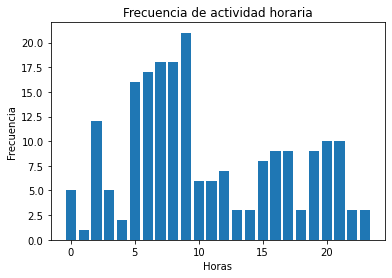

In [7]:
horas = registro_tweets.Hora.unique()
cantidad = registro_tweets.Hora.value_counts().tolist()
plt.bar(horas, cantidad)
plt.title("Frecuencia de actividad horaria")
plt.xlabel("Horas")
plt.ylabel("Frecuencia")


In [8]:
palabras_populares = {'palabras':list(top_words.keys()), 'repeticion':list(top_words.values()) }
palabras_populares = pd.DataFrame(palabras_populares)
palabras_populares_1 = palabras_populares.sort_values('repeticion', ascending=False)[:6]


En las palabras graficadas logra observarse que justamente las más mencionadas son energía y sostenible, puesto que corresponden a las palabras que se buscaron en las llamadas a la API, sin embargo, las demás palabras corresponden en su mayoría a los nombres de las alternativas de energía limpia, como solar, agua, etc., además de presentar otras palabras como cambio, eficiencia futuro, que aluden al hecho de que en gran parte de dichos tweets se hace referencia a la energía sostenible como una alternativa y lo que se pretende es instruir a las personas sobre el tema y convencerlas de las ventajas que esto podría tener.

<Figure size 7200x14400 with 0 Axes>

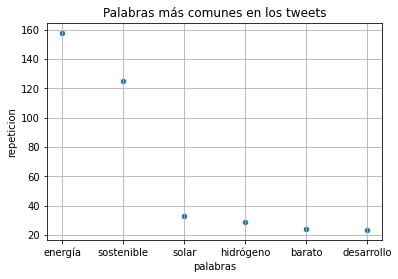

In [9]:
plt.figure(figsize = (100,200))
palabras_populares_1.plot('palabras', 'repeticion', kind = 'scatter')
plt.title("Palabras más comunes en los tweets")
plt.grid()

In [11]:
palabras_populares.sort_values('repeticion', ascending=False)[:16]

,palabras,repeticion
3,energía,158
15,sostenible,125
34,solar,33
35,hidrógeno,29
29,barato,24
228,desarrollo,23
282,agua,18
1290,electricidad,13
239,forma,13
427,paso,12


In [36]:
cuentas_populares = {'Cuenta_tweet':list(cuentas.keys()), 'Etiquetado':list(cuentas.values()) }
cuentas_populares = pd.DataFrame(cuentas_populares)
cuentas_populares = cuentas_populares.sort_values('Etiquetado', ascending=False)[:3]
cuentas_populares['Cuenta_tweet'] = cuentas_populares.Cuenta_tweet.apply(
    lambda x: x.split('@')[-1]
)
cuentas_populares['Cuenta_tweet'] = cuentas_populares.Cuenta_tweet.apply(
    lambda x: x.split('.')[0]
)
cuentas_populares['Cuenta_tweet'] = cuentas_populares.Cuenta_tweet.apply(
    lambda x: x.split(':')[0]
)
cuentas_populares

,Cuenta_tweet,Etiquetado
26,cienciaplus,4
27,petrogustavo,2
88,vidayexitorev,2


In [37]:

cuentas_populares['Seguidores'] = cuentas_populares.Cuenta_tweet.apply(lambda x: api.user_timeline(screen_name = x)[0]._json['user']['followers_count'])
cuentas_populares['Seguidos'] = cuentas_populares.Cuenta_tweet.apply(lambda x: api.user_timeline(screen_name = x)[0]._json['user']['friends_count'])
cuentas_populares

,Cuenta_tweet,Etiquetado,Seguidores,Seguidos
26,cienciaplus,4,444679,736
27,petrogustavo,2,6415310,2683
88,vidayexitorev,2,1176,143


Aunque tres cuentas no son suficientes para determinar el tipo de tendencia que gobierna el comportamiento de un suceso, sí podría realizarse una búsqueda más exhaustiva sobre las cuentas que publican este tipo de temas e identificar el comportamiento de las curvas que describe la relación entre los seguidores y los seguidos